In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import random


In [7]:
train_data_dir = "pathogen/test/"
validation_data_dir = "pathogen/validiation"

img_width, img_height = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2, # Belirtilen açı aralaığında görüntüyü rastgele kesiyor.
    zoom_range=0.2, # Belirlenan oran aralığında görüntüyü rastgele yakınlaştırıyor.
    horizontal_flip=True # Görüntüyü yatay eksende rastgele çeviriyor.
    )

validation_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="categorical"
)
    


validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=32, 
    class_mode="categorical")

Found 34909 images belonging to 5 classes.
Found 5003 images belonging to 5 classes.


In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output # Modelin son katmanının çıktısını ifade ediyor. 
# Yeni eklenen katmanlar için girişi için kullanılır.
x = GlobalAveragePooling2D()(x)  # Özellik haritasını tek bir vektöre dönüştürüyor, #Her bir kanaldaki ortalama değeri hesaplar ve
# ve bu değerleri tek bir vektörde birleştir.
x = Dense(1024, activation='relu')(x) # Her nöron için ktivasyon fonksiyonunu uygular
predictions = Dense(5, activation='softmax')(x)  # softmax değerleri 0 ile1 1 arasında tutuyor. #Dense sınf sayısına eşit olmalıdır.

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', # tahmin ettiği olasılık dağılımı ve gerçek sınıf etiketi arasındaki farkı hesaplıyor.
              optimizer='adam', # gradyan iniş algoritması
              metrics=['accuracy']) # doğruluk oranı

In [9]:
model.fit(
    train_generator, # eğitim verilerini sağlıyor.
    steps_per_epoch=train_generator.samples // train_generator.batch_size, # bir epocta kaç adım gerçekleştrileceği
    epochs=1, ## kaç epoch(döngü) boyunca eğitilecği
    validation_data=validation_generator, # doğrulama verisi oluşturma
    validation_steps=validation_generator.samples // validation_generator.batch_size # 
)
model.save("bitki_hastaligi_model.keras",include_optimizer=True)

c:\Users\Fhyci\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1090/1090 ━━━━━━━━━━━━━━━━━━━━ 983s 893ms/step - accuracy: 0.9130 - loss: 0.2461 - val_accuracy: 0.9669 - val_loss: 0.0987


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


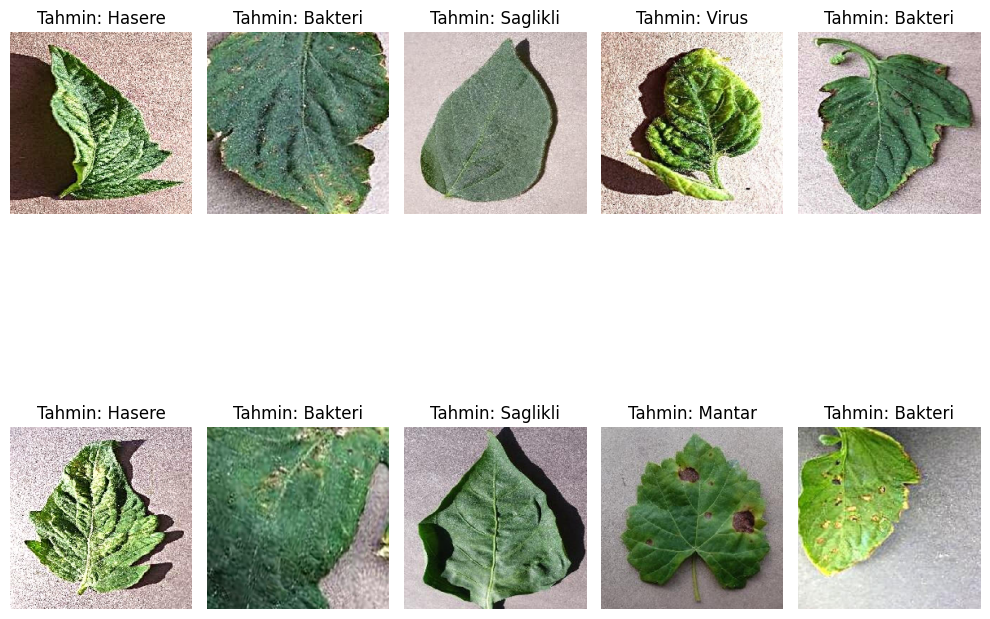

In [13]:
# Modeli ve sınıf isimlerini yükleyin
model = tf.keras.models.load_model("bitki_hastaligi_model.keras")
class_names = ["Bakteri", "Hasere", "Mantar", "Saglikli", "Virus"]

# Görüntülerin bulunduğu klasör yolunu belirtin
image_folder = "Rastgele/"

# Klasördeki tüm dosya isimlerini alın
image_files = os.listdir(image_folder)

# Rastgele 10 görüntü seçin
selected_images = random.sample(image_files, 10)

# Seçilen görüntüleri sınıflandırın ve görselleştirin
plt.figure(figsize=(10, 10))
for i, image_file in enumerate(selected_images):
    # Görüntü yolunu oluşturun
    img_path = os.path.join(image_folder, image_file)

    # Görüntüyü yükleyin ve yeniden boyutlandırın
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    # Tahmini sınıflandırmayı elde edin
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Görüntüyü alt çizim olarak ekleyin
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Tahmin: {predicted_class}")
    plt.axis("off")

# Tüm alt çizimleri gösterin
plt.tight_layout()
plt.show()